In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

ng_repo_path = '/home/alexn/neuroglancer_interface/'
sys.path.append(os.path.join( ng_repo_path, 'src'))
from ng_utilities import *
from ng_full_utilities_test import *

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

import matplotlib.pyplot as plt
%matplotlib inline

import neuroglancer
import cv2
import json

with open(ng_repo_path+'config/struct_to_color_2.json', 'r') as json_file:
    structure_to_color = json.load( json_file )
    
color_segments=[]
for i in range(1,29):
    color_segments.append(i)
    

with open(ng_repo_path+'config/stack_parameters_ng.json', 'r') as json_file:
    stack_parameters_ng = json.load( json_file )
    
stack1 = 'MD589'

detector_id = 19
# detector_id = 799

stack2 = 'MD594'

detector_id = 19
# detector_id = 799

ENABLE_UPLOAD_S3 is not set, default to False.
ENABLE_DOWNLOAD_S3 is not set, default to False.


Setting environment for Precision WorkStation for Alex Newberry
{'MD589': 0.46, 'MD585': 0.46, 'UCSD001': 0.325, 'MD594': 0.46, 'DK17': 0.325}
Loaded data from saved metadata_cache for MD585
Loaded data from saved metadata_cache for MD589
Loaded data from saved metadata_cache for MD594
Loaded data from saved metadata_cache for UCSD001


Folder for stack MD590 not found, skipping.
Folder for stack MD591 not found, skipping.
Folder for stack MD592 not found, skipping.
Folder for stack MD593 not found, skipping.
Folder for stack MD595 not found, skipping.
Folder for stack MD598 not found, skipping.
Folder for stack MD599 not found, skipping.
Folder for stack MD602 not found, skipping.
Folder for stack MD603 not found, skipping.
Folder for stack MD635 not found, skipping.
Folder for stack MD653 not found, skipping.
Folder for stack MD652 not found, skipping.
Folder for stack MD642 not found, skipping.
Folder for stack MD657 not found, skipping.
Folder for stack MD658 not found, skipping.
Folder for stack MD661 not found, skipping.
Folder for stack MD662 not found, skipping.
Folder for stack CHATM2 not found, skipping.
Folder for stack CHATM3 not found, skipping.


# Setup Viewer

In [2]:
neuroglancer.set_server_bind_address('0.0.0.0')
viewer = neuroglancer.Viewer()
print(viewer)

ip_name = !hostname -I
print('http://' + ip_name[0].strip() + ':' + viewer.get_viewer_url().split(':')[2]) ##Remote URL

ip_name_str = str(ip_name).replace('\'','').replace('\"','').replace('[','').replace(']','')
real_ip = ip_name_str.split(' ')[0]
print('http://' + real_ip + ':' + viewer.get_viewer_url().split(':')[2]) ##Remote URL

viewer # IP 132.239.73.85

http://yuncong-Precision-WorkStation-T7500:43151/v/88cb70e157d8f78b6b73201289aa66f20cc27f4a/
http://132.239.73.85 172.17.0.1:43151/v/88cb70e157d8f78b6b73201289aa66f20cc27f4a/
http://132.239.73.85:43151/v/88cb70e157d8f78b6b73201289aa66f20cc27f4a/


http://yuncong-Precision-WorkStation-T7500:43151/v/88cb70e157d8f78b6b73201289aa66f20cc27f4a/

In [3]:
# Sets 'Image' layer to be prep2 images from S3 of <stack>
with viewer.txn() as s:
    s.layers['image'] = neuroglancer.ImageLayer(source='precomputed://https://mousebrainatlas-datajoint-jp2k.s3.amazonaws.com/precomputed/'+stack1+'_fullres')
    
    # Resets X/Y/Z plane orientation
    s.navigation.pose.orientation = [0,0,0,1]
    # Zooms out 
#     s.navigation.zoomFactor = 10000 # If 4panel
    s.navigation.zoomFactor = 5000 # If xy
    
    # Resets 3D Viewer Orientation
    s.perspectiveOrientation = [0,0,0,1]
    # Zooms out
    s.perspectiveZoom = 75000
    
    s.layout = 'xy' # '3d'/'4panel'/'xy'

In [9]:
vol1_fp = NEUROGLANCER_ROOT+'/'+stack1+'/human_annotation/solid_volume_5um/volume_colored.npy'
vol2_fp = NEUROGLANCER_ROOT+'/'+stack2+'/human_annotation/solid_volume_5um/volume_colored.npy'

vol1 = np.load(vol1_fp)
vol2 = np.load(vol2_fp)

# Make vol1 monocolor
# z_len, y_len, x_len = np.shape(vol1)
# for z in range(z_len):
#     for y in range(y_len):
#         for x in range(x_len):
#             if vol1[z,y,x]!=0:
#                 vol1[z,y,x] = 1

# Make vol2 monocolor
# z_len, y_len, x_len = np.shape(vol2)
# for z in range(z_len):
#     for y in range(y_len):
#         for x in range(x_len):
#             if vol2[z,y,x]!=0:
#                 vol2[z,y,x] = 2

vol1_nonzero_indices = vol1 > 0
vol1[vol1_nonzero_indices] = 1

vol2_nonzero_indices = vol2 > 0
vol2[vol2_nonzero_indices] = 2

In [10]:
import scipy as sp
vol2_rot = vol2.copy()
z_len, y_len, x_len = np.shape(vol2)
# for z in range(80,90):
for z in range( z_len ):
    # Positive rotation is CounterClockwise
    # Negative rotation is Clockwise
    vol2_rot[z,:,:] = sp.ndimage.rotate(vol2_rot[z,:,:], -25, reshape=False)
    

    
xy_ng_resolution_um = 5

with viewer.txn() as s:
    s.layers[ 'vol2_rot' ] = neuroglancer.SegmentationLayer(
        source = neuroglancer.LocalVolume(
            data=vol2_rot, # Z,Y,X
            voxel_size=[ xy_ng_resolution_um*1000, xy_ng_resolution_um*1000,20000], # X Y Z
            voxel_offset = [ 30, 90, 0] # X Y Z
        ),
        segments = [i for i in range(50)]
    )

In [11]:
with viewer.txn() as s:
    s.layers[ 'vol2_rot' ] = neuroglancer.SegmentationLayer(
        source = neuroglancer.LocalVolume(
            data=vol2_rot, # Z,Y,X
            voxel_size=[ xy_ng_resolution_um*1000, xy_ng_resolution_um*1000,20000], # X Y Z
            voxel_offset = [ 30, 90, 0] # X Y Z
        ),
        segments = [i for i in range(50)]
    )

In [12]:

with viewer.txn() as s:
    s.layers[ 'vol1' ] = neuroglancer.SegmentationLayer(
        source = neuroglancer.LocalVolume(
            data=vol1, # Z,Y,X
            voxel_size=[ xy_ng_resolution_um*1000, xy_ng_resolution_um*1000,20000], # X Y Z
            voxel_offset = [ 0, 0, 0] # X Y Z
        ),
        segments = [i for i in range(50)]
    )
    
with viewer.txn() as s:
    s.layers[ 'vol2' ] = neuroglancer.SegmentationLayer(
        source = neuroglancer.LocalVolume(
            data=vol2, # Z,Y,X
            voxel_size=[ xy_ng_resolution_um*1000, xy_ng_resolution_um*1000,20000], # X Y Z
            voxel_offset = [ 0, 0, 0] # X Y Z
        ),
        segments = [i for i in range(50)]
    )

In [51]:
neuroglancer.stop()

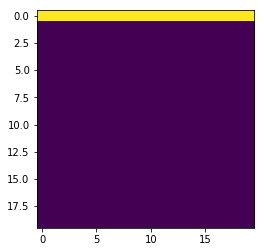

In [37]:
x = np.zeros((20,20))
x[0,:] = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

plt.imshow(x)